In [ ]:
!pip install --upgrade datasets

In [1]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import TensorDataset, DataLoader
import torch
from tqdm.auto import tqdm
import copy
from torch import nn
import numpy as np
import gc
import matplotlib.pyplot as plt

In [ ]:
datasets = load_dataset("huggingartists/xxxtentacion")

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenized_dataset = datasets.map(
    lambda x: tokenizer(
        x['text'],
        padding='max_length',
        max_length=512,
        truncation=True
    ),
    batched=True
)

In [ ]:
train_dataset = TensorDataset(torch.tensor(tokenized_dataset['train']['input_ids']),
                              torch.tensor(tokenized_dataset['train']['attention_mask']))
train_dataloader = DataLoader(train_dataset, batch_size=8)

In [5]:
def generate_sample(model, tokenizer, device, prompt=""):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=100,
            do_sample=True,
            top_k=50,
            temperature=1,
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(output[0], skip_special_tokens=True)

def train_GPT(model, train_dataloader, device, epochs=5):
    prompt = """
    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music
    """
    model = copy.deepcopy(model)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters())

    losses = []
    style_samples  = []
    perplexity = []

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        losses_per_epoch = []

        progress_bar = tqdm(train_dataloader, desc=f'Epoch: {epoch + 1}')
        for batch in progress_bar:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            losses_per_epoch.append(loss.item())
            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = np.mean(losses_per_epoch)
        losses.append(avg_loss)

        perplex = np.exp(avg_loss)
        perplexity.append(perplex)
        sample = generate_sample(model, tokenizer, device, prompt)
        style_samples.append(sample)

        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {avg_loss:.4f} | Perplexity: {perplex:.4f}")
        print("Generated Sample:")
        print(sample + "\n")


    return model, losses, perplexity

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()
model = GPT2LMHeadModel.from_pretrained('gpt2')
train_model, loss, preplex = train_GPT(model, train_dataloader, device, 10)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Epoch: 1:   0%|          | 0/98 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Epoch 1
Train Loss: 2.1751 | Perplexity: 8.8029
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
      Description: Hi! Answer as accurately as possible. You can say no, no, no, no
My nigga bitch, fuck me, fuck me
You are talking, yeah
My nigga bitch, fuck me, fuck me, fuck me



Epoch: 2:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 2
Train Loss: 1.4149 | Perplexity: 4.1161
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
    
We could just had... Ayy
A: Hey!
Okay, do you have me friend?
Okay
Alright
Okay
Alright
Okay
Okay, okay
We could just had... Ayy
A: Hey!
Okay




Epoch: 3:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 3
Train Loss: 1.1308 | Perplexity: 3.0981
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
     двоya! траит нитв но ито � ке траит и



Epoch: 4:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 4
Train Loss: 0.8875 | Perplexity: 2.4291
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
     
Selfish Ive confessed my feelings multiple times
And she denied that Ive confessed them multiple times
And she told me Im not used to chasing, chasing 
And no, Ive confessed my feelings multiple times
And she denied that I



Epoch: 5:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 5
Train Loss: 0.6988 | Perplexity: 2.0112
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
    
You really are not that person
It makes me colder
Ice on my neck
Snow on my neck
Snow on my neck
Ice
Snow on my neck
Whirls on my neck
Whats that on my neck?
Whats



Epoch: 6:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 6
Train Loss: 0.5484 | Perplexity: 1.7305
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
    
How you doing this?
Verse 1: Necrium
Verse 2: Smitty, coke addict
Ice under my heels, bitch 
I feel like smoking , or distributing mail 
You wanna end this shit, please no,



Epoch: 7:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 7
Train Loss: 0.4361 | Perplexity: 1.5466
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
      Please dont throw your all away, please dont throw your all away
Please dont throw your all away, please dont throw your all away, please dont throw your away
Dont throw your all away, please dont throw your away, please dont throw



Epoch: 8:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 8
Train Loss: 0.3463 | Perplexity: 1.4138
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
    умаюt hi
 ракиз, чуй тамаю коль те мебраже, те �



Epoch: 9:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 9
Train Loss: 0.2728 | Perplexity: 1.3136
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
    я  might be best to date ayy 
Love isn’t easy in this lifestyle were all lies
Wanna deal with someone else girl you know you love you again
But girl, I hate it when you give them lots of items




Epoch: 10:   0%|          | 0/98 [00:00<?, ?it/s]


Epoch 10
Train Loss: 0.2142 | Perplexity: 1.2388
Generated Sample:

    Description: Hi! Answer as naturally as possible. You're chatting with a person, so you don't need to repeat your phrases much
    Request: Let's talk about music 
    
We were in the studio 
 
Its recording now 
I got a new groove
Stupid shit, its a shame 
Fell in love with disappearing, I love it when we get it turned around
Yeah yeah I love it



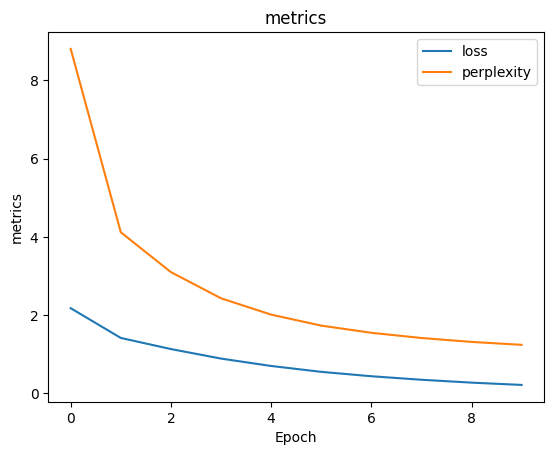

In [7]:
plt.plot(loss, label='loss')
plt.plot(preplex, label='perplexity')
plt.title('metrics')
plt.xlabel('Epoch')
plt.ylabel('metrics')
plt.legend()

In [8]:
prompt = """
stop repeating the same words, and answer naturally
question: Lets talk about music
"""
sample = generate_sample(train_model, tokenizer, device, prompt)
print(sample)


stop repeating the same words, and answer naturally
question: Lets talk about music
We as a nation give rise to this man
This world is so ice, I cannot understand it
My anxiety and troubles over people who never gave a fucking care
Im charging and putting the people down to where they’re nowhere 
This soothes me, I feel my anxiety and troubles over people who never gave a fucking care 
This soothes me, I feel my anxiety and troubles


In [9]:
output_dir = "/content/save"
train_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Модель сохранена в {output_dir}")

Модель сохранена в /content/save


In [10]:
!zip -r model.zip /content/save/
from google.colab import files
files.download('model.zip')

  adding: content/save/ (stored 0%)
  adding: content/save/special_tokens_map.json (deflated 74%)
  adding: content/save/model.safetensors (deflated 7%)
  adding: content/save/merges.txt (deflated 53%)
  adding: content/save/generation_config.json (deflated 24%)
  adding: content/save/vocab.json (deflated 68%)
  adding: content/save/config.json (deflated 51%)
  adding: content/save/tokenizer_config.json (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>